Download the dataset

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("grouplens/movielens-20m-dataset")

print("Path to dataset files:", path)

Path to dataset files: /home/pavka/.cache/kagglehub/datasets/grouplens/movielens-20m-dataset/versions/1


In [23]:
import numpy
import pandas as pd
import random
from sympy import isprime
import matplotlib.pyplot as plt

## <strong> 1. Recommendation System with LSH

## <strong> 1.1 Data Preparation
Download the MovieLens dataset from here. After downloading, explore the dataset to understand the structure and identify any preprocessing steps needed.

<strong> There are in total 6 datasets, let's have a quick look at them

In [3]:
genome_scores = pd.read_csv("dataset/genome_scores.csv", index_col =0)
genome_scores.head(3)

,tagId,relevance
movieId,,
1,1,0.02500
1,2,0.02500
1,3,0.05775


In [4]:
genome_tags = pd.read_csv("dataset/genome_tags.csv", index_col = 0)
genome_tags.head(3)

,tag
tagId,
1,007
2,007 (series)
3,18th century


In [5]:
link = pd.read_csv("dataset/link.csv", index_col = 0)
link.head(3)

,imdbId,tmdbId
movieId,,
1,114709,862.0
2,113497,8844.0
3,113228,15602.0


In [6]:
movie = pd.read_csv("dataset/movie.csv", index_col = 0)
movie.head(3)

,title,genres
movieId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance


In [7]:
rating = pd.read_csv("dataset/rating.csv", nrows=10000)
rating.head(3)

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39


In [8]:
tag = pd.read_csv("dataset/tag.csv", index_col = 0)
tag.head(3)

,movieId,tag,timestamp
userId,,,
18,4141,Mark Waters,2009-04-24 18:19:40
65,208,dark hero,2013-05-10 01:41:18
65,353,dark hero,2013-05-10 01:41:19



## <strong>1.2 Minhash Signatures</strong>

Using the userId and movieId columns, implement your own MinHash function. This function will hash each user's watched movie list, creating a representation that allows for quick comparisons of user similarities.

    -Important: Implement your MinHash function from scratch—do not use any pre-built hash functions.
    -Use your MinHash function to generate signature vectors for each user based on their rated movies.
    -Experiment with different hash functions and threshold values to find the most effective configurations. Report these results.


Let's first group all the users and their correspective movies.

In [ ]:
user_movies = rating.groupby('userId')['movieId'].apply(list).to_dict()

Let's define a simple modulo hash function: <br> <br>
$
h(x) = (a \cdot x + b) \mod p
$

Where:  
- $ x $: Input value  
- $ a $: Coefficient (non-zero)  
- $ b $: Coefficient  
- $ p $: Prime modulus

In [ ]:
def hash_function(x, a ,b ,p): 
    return (a*x + b) % p

We generate multiple hash functions.

In [11]:
def create_hash_functions(max_value, max_prime):
    
    primes = [i for i in range(10,max_prime) if isprime(i)]

    # Generate multiple hash functions
    hash_functions = []
    for i in range(10):
        a = random.randint(1, max_value)  # Random coefficient a (non-zero)
        b = random.randint(0, max_value)  # Random coefficient b
        p = random.choice(primes)  # Predefined prime values
        
        hash_functions.append(lambda x, a=a, b=b, p=p: hash_function(x, a, b, p))
    return hash_functions

Now given these hash functions, we create our signature matrix.

In [12]:
def minhash(user_movies, hash_functions):
    signature_matrix = {}

    for user, movies in user_movies.items():
        signature_vector = []
        for h in hash_functions:
            min_hash = min(h(movie) for movie in movies)  # Compute min hash value for the user's movies
            signature_vector.append(min_hash)
        signature_matrix[user] = signature_vector
    
    return signature_matrix

### **Effectiveness of the Hashing Function**

To evaluate the effectiveness of our MinHash function, we compare the **Jaccard similarity** of two sets with the **MinHash similarity** of their corresponding signature matrices. We then calculate the error using the squared Euclidean distance between the two similarities.

#### 1. **Jaccard Similarity**

The Jaccard similarity between two sets $A $ and $B $ is defined as:

$
J(A, B) = \frac{|A \cap B|}{|A \cup B|}
$

#### 2. **MinHash Similarity**

The MinHash similarity between two signature vectors $\text{sig}_1 $ and $\text{sig}_2 $ is given by:

$
\text{MinHashSim}(\text{sig}_1, \text{sig}_2) = \frac{\text{Number of Matching Hashes}}{\text{Total Number of Hashes}}
$

$
\text{MinHashSim}(\text{sig}_1, \text{sig}_2) = \frac{\sum_{i=1}^n \mathbb{1}(\text{sig}_1[i] = \text{sig}_2[i])}{n}
$

where $\mathbb{1} $ is the indicator function that returns $1 $ if the elements are equal and $0 $ otherwise.

#### 3. **Error Calculation**

The error is computed as the squared Euclidean distance between the true Jaccard similarity and the MinHash similarity:

$
\text{Error} = (J(A, B) - \text{MinHashSim}(\text{sig}_1, \text{sig}_2))^2
$

#### 4. **Total Error Across Users**

For all pairs of users \((u_1, u_2)$, the total error is computed as:

$
\text{Total Error} = \frac{\sum_{(u_1, u_2) \in \text{Users}} \text{Error}(u_1, u_2)}{|\text{Users}|^2}
$

Where:
- $\text{Users} $ is the set of all user pairs.
- $\text{Error}(u_1, u_2) $ is the squared Euclidean error for a pair of users.


In [30]:
from itertools import combinations

# For simplicity we only ran 10000 lines including 90 users

# True Jaccard similarity
def jaccard_similarity(set1, set2):
    return len(set1.intersection(set2)) / len(set1.union(set2))

# MinHash similarity
def minhash_similarity(sig1, sig2):
    return sum(1 for a, b in zip(sig1, sig2) if a == b) / len(sig1)

# Evaluate effectiveness
def evaluate_effectiveness(user_movies, signature_matrix):
    users = list(user_movies.keys())

    tot_error = 0
    for user1, user2 in combinations(users, 2):
        set1, set2 = set(user_movies[user1]), set(user_movies[user2])
        sig1, sig2 = signature_matrix[user1], signature_matrix[user2]
        
        # Compute similarities
        true_jaccard = jaccard_similarity(set1, set2)
        approx_minhash = minhash_similarity(sig1, sig2)
        
        # Calculate Error
        error = (true_jaccard - approx_minhash)**2
        tot_error += error
    
    return tot_error / (len(users)**2)


Let's test our results given different types of values for the hashing function.

In [31]:
results = []
parameters = []
for i in range(10,1000,5):
    parameters.append(i)
    hash_functions = create_hash_functions(i, i*2)
    signature_matrix = minhash(user_movies,hash_functions)
    result = evaluate_effectiveness(user_movies,signature_matrix)
    results.append(result)

Let's plot the results.

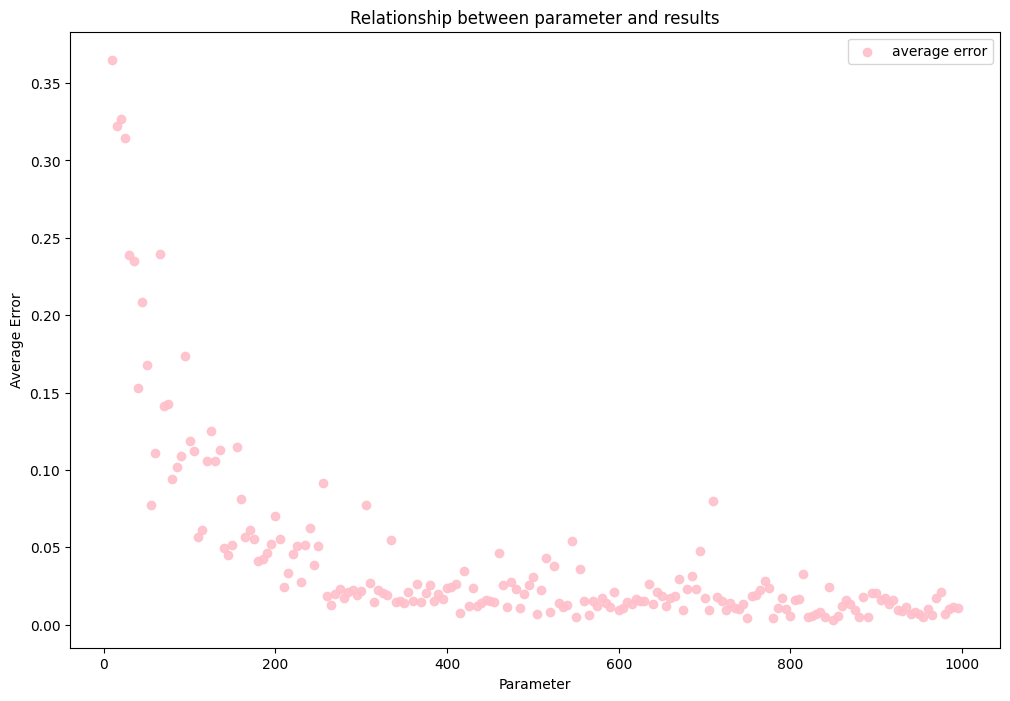

In [40]:
plt.figure(figsize=(12, 8))  
plt.scatter(parameters, results, color='pink', label='average error',alpha = 0.9)  # Plot points
plt.title("Relationship between parameter and results")  
plt.xlabel("Parameter") 
plt.ylabel("Average Error") 
plt.legend() 
plt.show()

We can clearly see a direct relationship between the maximum value in the hashing function and the error. As the maximum value grows, the likelihood of hash collisions decreases, resulting in a better approximation of the true Jaccard similarity and a reduction in error.